<a href="https://colab.research.google.com/github/7029279/matoson/blob/main/matoson8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/13827 [00:00<?, ?it/s]

  0%|          | 0/1537 [00:00<?, ?it/s]

train_dataset: 29112, test_dataset: 3195 


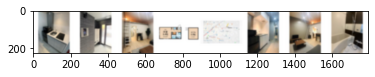

torch.Size([2, 1280])
torch.Size([2, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 896]             864
       BatchNorm2d-2         [-1, 32, 112, 896]              64
              SiLU-3         [-1, 32, 112, 896]               0
            Conv2d-4         [-1, 32, 112, 896]             288
       BatchNorm2d-5         [-1, 32, 112, 896]              64
              SiLU-6         [-1, 32, 112, 896]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 896]               0
           Conv2d-13         [-1, 16, 112, 896]             51

In [ ]:
#!/usr/bin/python
# encoding: utf-8

import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import SmoothL1Loss
from torch.utils.data import Dataset
from torch.utils.data import sampler
from torch.optim import RAdam
from  torch.optim.lr_scheduler import ExponentialLR
from torchsummary import summary
import torch.nn as nn
from torchvision import models


import numpy as np
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
from PIL import Image
import math
import os
from tqdm.notebook import tqdm

!pip install gspread==3.7.0 --quiet 
import gspread
from google.colab import drive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()



gc = gspread.authorize(GoogleCredentials.get_application_default())

drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/pricing")

ss_id = "1DcQBLsJAJ14OrhkdaWTzIzQmdY5B4FfV54d75CA2e60"
workbook = gc.open_by_key(ss_id)


data_sheeet = workbook.worksheet("マンスリーポータルスクレイピング")

data = data_sheeet.get_all_records()


#URL	Area URL	price	built_year	layout	size	station	eki_toho	station2	eki_toho2	station3	eki_toho3	address	autolock	delivery_box	bath_toilet	sennmenjo_dokurirtsu	chintai_average	chintai_station	chintai_station2	chintai_station3	tokyo	shinjuku	ikebukuro	shinagawa	tokyo2	shinjuku2	ikebukuro2	shinagawa2	monthly_price_average	month_count

def is_float(element):
    try:
        float(element)
        return True
    except ValueError:
        return False

def make_list(data, split):

    train_path_list, val_path_list = [], []
    train_price_list, val_price_list = [], []
    train_info_list, val_info_list = [], []

    random.shuffle(data)
    split_point = math.floor(len(data)*split)
    train_data = data[:split_point]
    val_data = data[split_point:]
    
    
    for one_row in tqdm(train_data):
      
      if not is_float(one_row["built_year"]) or not is_float(one_row["size"])  or not is_float(one_row["eki_toho"])  or not is_float(one_row["chintai_average"])  or not is_float(one_row["monthly_price_average"]):
        #print(one_row["built_year"])
        continue
      
      built_year = float(one_row["built_year"])/2022
      size = float(one_row["size"])/100
      eki_toho = float(one_row["eki_toho"])/50
      chintai_average = float(one_row["chintai_average"])/30
      monthly_price_average = float(one_row["monthly_price_average"])/300000
      month_count = float(one_row["month_count"])/200

      info = [eki_toho, built_year, size, chintai_average, monthly_price_average, month_count]
      
      imgs = ["pics_large/"+one_row["URL"].split("=")[1]+"_0.jpg","pics_large/"+one_row["URL"].split("=")[1]+"_1.jpg",
              "pics_large/"+one_row["URL"].split("=")[1]+"_2.jpg","pics_large/"+one_row["URL"].split("=")[1]+"_3.jpg"]
              
      for img in imgs:
        if os.path.exists(img):
          train_path_list.append(img)
          train_price_list.append(one_row["price"])
          train_info_list.append(info) #6 items

    for one_row in tqdm(val_data):
      
      if not is_float(one_row["built_year"]) or not is_float(one_row["size"])  or not is_float(one_row["eki_toho"])  or not is_float(one_row["chintai_average"])  or not is_float(one_row["monthly_price_average"]):
        #print(one_row["built_year"])
        continue
      
      built_year = float(one_row["built_year"])/2022
      size = float(one_row["size"])/100
      eki_toho = float(one_row["eki_toho"])/50
      chintai_average = float(one_row["chintai_average"])/30
      monthly_price_average = float(one_row["monthly_price_average"])/300000
      month_count = float(one_row["month_count"])/200

      info = [eki_toho, built_year, size, chintai_average, monthly_price_average, month_count]
      
      imgs = ["pics_large/"+one_row["URL"].split("=")[1]+"_0.jpg","pics_large/"+one_row["URL"].split("=")[1]+"_1.jpg",
              "pics_large/"+one_row["URL"].split("=")[1]+"_2.jpg","pics_large/"+one_row["URL"].split("=")[1]+"_3.jpg"]
              
      for img in imgs:
        if os.path.exists(img):
          val_path_list.append(img)
          val_price_list.append(one_row["price"])
          val_info_list.append(info) #6 items
    
    return train_path_list, train_price_list, val_path_list, val_price_list, train_info_list, val_info_list


 

class custom_Dataset(Dataset):
    def __init__(self, phase, path_list=None, info_list=None, price_list=None, size=224, divide_by=300000, limit=None):
        self.path_list = path_list
        self.price_list = price_list
        self.divide_by = divide_by
        self.size = size
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]
       
        if phase == "train":
          self.transform = transforms.Compose([
            #transforms.Resize((self.size,self.size)),
            transforms.ColorJitter(),
            transforms.RandomGrayscale(0.3),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.GaussianBlur(kernel_size=3),
            transforms.ToTensor(),
            transforms.RandomErasing(),
            transforms.Normalize(mean, std)
           ])
   
        elif phase == "val":
          self.transform = transforms.Compose([
          #transforms.Resize((self.size,self.size)),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
          ])
        
        self.info_list = info_list

        if limit is None:
            self.nSamples = len(self.path_list)
        else:
            self.path_list = self.path_list[:limit]
            self.nSamples = len(self.path_list)

    def __len__(self):
            return self.nSamples

    def __getitem__(self, index):

        #C,W,H
        img_out =self.transform(Image.open(self.path_list[index]).convert("RGB"))
                                
        info_out = torch.as_tensor(self.info_list[index])

        price_out = self.price_transform(self.price_list[index])


        return (img_out, info_out, price_out)


    def price_transform(self, price): 
        return torch.as_tensor([price/self.divide_by])


s = torch.as_tensor([0.229, 0.224, 0.225])
m = torch.as_tensor([0.485, 0.456, 0.406])

def unnorm(img, mean=m, std=s):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img 
    
def debug ():
  to_image = transforms.ToPILImage()
  train_path_list, train_price_list, val_path_list, val_price_list, train_info_list, val_info_list= make_list(data, split=0.9)

  train_set = custom_Dataset(phase="train", path_list=train_path_list, info_list=train_info_list, price_list=train_price_list, size=224, divide_by=300000, limit=None)
  val_set = custom_Dataset(phase="val", path_list=val_path_list, info_list=val_info_list, price_list=val_price_list, size=224, divide_by=300000, limit=None)


  print(f"train_dataset: {train_set.__len__()}, test_dataset: {val_set.__len__()} ")

  plt.imshow(to_image(unnorm(val_set.__getitem__(0)[0])), interpolation="bicubic")
  plt.show()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  

  net = models.efficientnet_b1(pretrained=True)

  def _forward_impl_mod(x, y=None) :
      x = net.features(x)

      x = net.avgpool(x)
      x = torch.flatten(x, 1)

      #print(x.size()) # =>  2, 2560 
      if not y: 
        y = torch.rand(2,6).to(device)
        print(x.size())
      x = torch.cat((x, y), 1).to(device)
      x = net.classifier(x)
      print(x.size())

      return x
  
  net._forward_impl = _forward_impl_mod
  net.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(320*4+6, 40), #10 => [[5], [5]] #320*4+6-1 # 448*4+6
                                nn.Dropout(0.2), nn.Linear(40, 30),  nn.SiLU(inplace=True),
                                nn.Dropout(0.2), nn.Linear(30, 20),  nn.SiLU(inplace=True),
                                nn.Dropout(0.2), nn.Linear(20, 10),  nn.SiLU(inplace=True),
                                nn.Dropout(0.2), nn.Linear(10, 1),)  
  
  
  summary(net.to(device), (3,224*1,224*8))

#debug()


In [ ]:


cudnn.benchmark = True
torch.cuda.empty_cache()
seed = 10
random.seed(seed)  
np.random.seed(seed)  
# PyTorch のRNGを初期化  
torch.manual_seed(seed)  

def train_main(name="training", resume=False):
    lr =  0.0001 #learning rate 
    step_count = 20
    step_rate = 0.7
    nepoch = 40
    size = 224 
    num_workers = 2
    batch_size = 8
    price_divide = 300000
    save_freq = 1000

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: ", device)
    train_path_list, train_price_list, val_path_list, val_price_list, train_info_list, val_info_list= make_list(data, split=0.95)

    train_set = custom_Dataset(phase="train", path_list=train_path_list, info_list=train_info_list, price_list=train_price_list, size=size, divide_by=price_divide, limit=None)
    val_set = custom_Dataset(phase="val", path_list=val_path_list, info_list=val_info_list, price_list=val_price_list, size=size, divide_by=price_divide, limit=None)

    del train_path_list, train_price_list, val_path_list, val_price_list, train_info_list, val_info_list

    print(f"train_dataset: {train_set.__len__()}, test_dataset: {val_set.__len__()} ")

    train_loader = DataLoader(train_set, shuffle=True, batch_size = batch_size, num_workers=num_workers)
    val_loader = DataLoader(val_set, shuffle=False
                            , batch_size = batch_size, num_workers=num_workers)
    
    dataloaders_dict = {"train": train_loader, "val": val_loader}
    
    to_image = transforms.ToPILImage()
    record = []

    net = models.efficientnet_b1(pretrained=True)
    

    def _forward_impl_mod(x, y):
      x = net.features(x)

      x = net.avgpool(x)
      x = torch.flatten(x, 1)

      #print(x.size()) # =>  batch_size4, 2560
      #print(y.size()) # =>  batch_size4 10
      x = torch.cat((x, y), 1)
      x = net.classifier(x)
      #print(x.size()) #torch.Size([4, 1])

      return x
     
    def forward_mod(x, y):
        return net._forward_impl(x, y)

    #b4 448, b7 640
  
    net._forward_impl = _forward_impl_mod
    net.forward = forward_mod
    net.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(320*4+6, 40), #10 => [[5], [5]] #320*4+6-1 # 448*4+6
                                nn.Dropout(0.2), nn.Linear(40, 30), nn.SiLU(inplace=True),
                                nn.Dropout(0.2), nn.Linear(30, 20), nn.SiLU(inplace=True),
                                nn.Dropout(0.2), nn.Linear(20, 10), nn.SiLU(inplace=True),
                                nn.Dropout(0.2), nn.Linear(10, 1),)  

    
    #https://pytorch.org/vision/stable/_modules/torchvision/models/efficientnet.html#efficientnet_b7
    
 
    net = net.to(device)
    #summary(net,(3,int(224*2),int(224*2)))
    
    if resume:
      net.load_state_dict(torch.load(name+".pth", map_location=device), strict=False)
      record = pd.read_csv(f'{name}.csv', header=1).values()
    optimizer = RAdam(net.parameters(),lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=step_rate)

    criterion = SmoothL1Loss(reduction='mean')
   
    time_holder = time.time()
    iteration = 0
    for epoch in range(nepoch):
      val_loss_container = []
      train_loss_container = []
      error_container = []
      time_holder = time.time()
      for phase in ['train', 'val']:
          if phase == 'train':
            net.train()  # モデルを訓練モードに
          else:
            net.eval()   # モデルを検証モードに
          
          # データローダーからminibatchずつ取り出すループ
          for images, info, targets in tqdm(dataloaders_dict[phase]):

              # GPUが使えるならGPUにデータを送る
              images = images.to(device)
              targets = targets.to(device)
              info = info.to(device)

              # optimizerを初期化
              optimizer.zero_grad()

              # 順伝搬（forward）計算
              with torch.set_grad_enabled(phase == 'train'):
                  # 順伝搬（forward）計算
                  outputs = net(images, info)
                  #print(outputs)
                  #print(targets)

                  # 損失の計算
                  loss= criterion(outputs, targets)
                  #print(loss)

                  # 訓練時はバックプロパゲーション
                  if phase == 'train':
                      loss.backward()  # 勾配の計算
                      iteration = iteration+1

                      # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                      nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)

                      
                      optimizer.step()
                      train_loss_container.append(loss.item())

                      if iteration % save_freq == 0:
                        torch.save(net.state_dict(), name+".pth")

                  else:
                      if len(val_loss_container) ==0:
                        for index, image in enumerate(images):
                          
                          plt.imshow(to_image(unnorm(image)), interpolation="bicubic")
                          plt.show()
                          print(f"actual:{math.floor(targets[index].item()*price_divide)}, prediction:{math.floor(outputs[index].item()*price_divide)}")
                          
                      val_loss_container.append(loss.item())
                      error_container.append(torch.mean(torch.abs(outputs-targets)).item()*price_divide)
                        
      train_loss_avg =  sum(train_loss_container)/len(train_loss_container)
      val_loss_avg =  sum(val_loss_container)/len(val_loss_container)
      error_avg = sum(error_container)/len(error_container)
      print(f"[{epoch}/{nepoch}] train_loss: {train_loss_avg} val_loss: {val_loss_avg} error_avg: {error_avg} time {time.time()-time_holder}")
      torch.save(net.state_dict(), name+".pth")

      record.append([epoch, train_loss_avg, val_loss_avg, error_avg])

      df = pd.DataFrame(record, columns=["epoch", "train_loss", "val_loss", "error_average"])
      df.to_csv(f'{name}.csv', index=False)
     
      
      
      
train_main(name="training3", resume=False) #"matoson.pth"

device:  cuda:0


  0%|          | 0/14595 [00:00<?, ?it/s]

  0%|          | 0/769 [00:00<?, ?it/s]

train_dataset: 30696, test_dataset: 1611 


  0%|          | 0/3837 [00:00<?, ?it/s]